In [1]:
!git clone https://www.github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16
Receiving objects: 100% (19/19), 3.30 MiB | 1.48 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import torch
from torchvision import models

In [10]:
vgg = models.vgg19(pretrained=True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
for params in vgg.parameters():
    params = params.requires_grad_(False)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cpu


In [22]:
from PIL import Image
from torchvision import transforms as T

In [77]:
def preprocess(img_path, max_size = 500):
    
    image = Image.open(img_path).convert('RGB')
    size = min(max_size, max(image.size))
    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    image = img_transforms(image)
    image = image.unsqueeze(0)
    return image

In [78]:
content_p = preprocess('Project-NST/content11.jpg')
style_p = preprocess('Project-NST/style12.jpg')

In [79]:
content_p = content_p.to(device)
style_p = style_p.to(device)

print(f'Content Shape: {content_p.shape}\nStyle shape: {style_p.shape}')

Content Shape: torch.Size([1, 3, 259, 345])
Style shape: torch.Size([1, 3, 625, 500])


In [80]:
import numpy as np
import matplotlib.pylab as plt

In [81]:
def deprocess(tensor):
    image = tensor.to('cpu').clone()
    image = image.numpy()
    image = image.squeeze(0)
    image = image.transpose(1,2,0)
    image = image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    image = image.clip(0,1)
    
    return image

In [82]:
content_d.shape

(259, 345, 3)

In [83]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

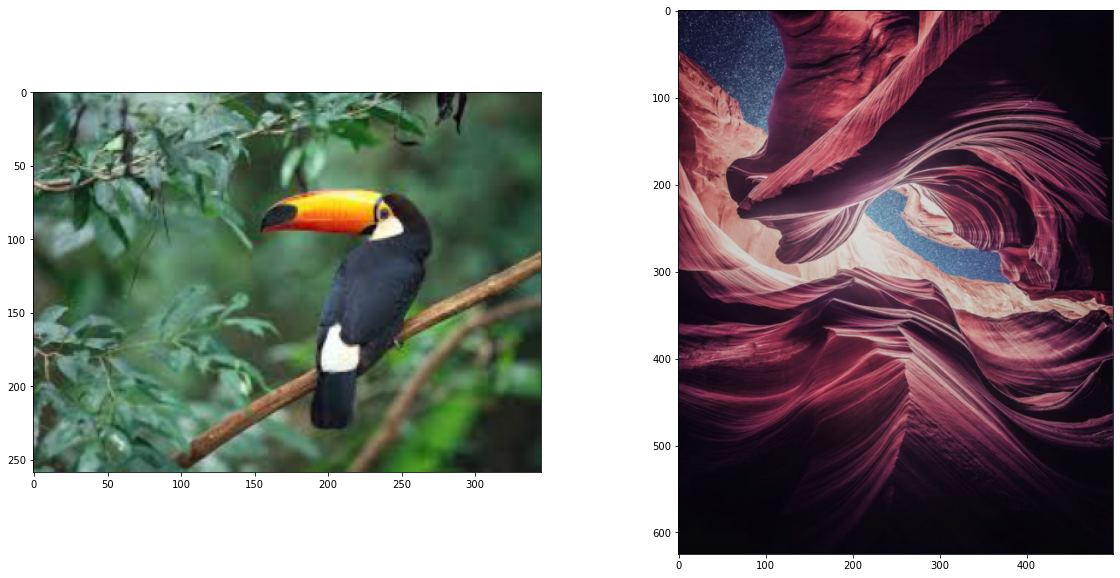

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content_d)
ax2.imshow(style_d)
plt.show()

In [94]:
def get_features(image, model):
    layers = ['0', '5', '10', '19', '21', '28']
    
    Features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in layers:
            Features[name] = x
    return Features

In [95]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

In [89]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [97]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

In [98]:
def content_loss(target_tensor, content_tensor):
    loss = torch.mean((target_tensor - content_tensor)**2)
    return loss

In [99]:
style_weights = {
    '0':1.0,
    '5':0.75,
    '10':0.2,
    '19':0.2,
    '28':0.2
}

In [114]:
def style_loss(target_features, style_grams, style_weights=style_weights):
    loss=0
    for layer in style_weights:
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
        
        b,c,h,w = target_f.shape
        loss+=layer_loss/(c*h*w)
    return loss

In [115]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)

print(f'Content loss:\t {content_loss(target_f["21"], content_f["21"])}')
print(f'Style loss:\t {style_loss(target_f, style_grams)}')

Content loss:	 0.0
Style loss:	 1790.841064453125


In [116]:
from torch import optim

In [120]:
optimizer = optim.Adam([target], lr=0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [121]:
def total_loss(c_loss, s_loss, alpha=alpha, beta=beta):
    total_loss = c_loss*alpha+s_loss*beta
    return total_loss

In [ ]:
results = []

for i in range(epochs):
    target_f = get_features(target, vgg)
    c_loss = content_loss(target_f['21'], content_f['21'])
    s_loss = style_loss(target_f, style_grams)
    
    t_loss = total_loss(c_loss, s_loss)
    
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()
    
    if i%show_every==0:
        print(f'loss:{t_loss}')
        results.append(deprocess(target.detach()))

loss:158353312.0


In [ ]:
plt.figure(figsize = (10,8))

for i in range(len(results)):
    plt.subplot(3, 2, i+1)
    plt.imshow(results[i])
    
plt.show()